In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [4]:
# input image dimensions
img_rows, img_cols = 32, 32

In [5]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [7]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (32, 32, 3)


In [8]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

In [9]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size = batch_size)

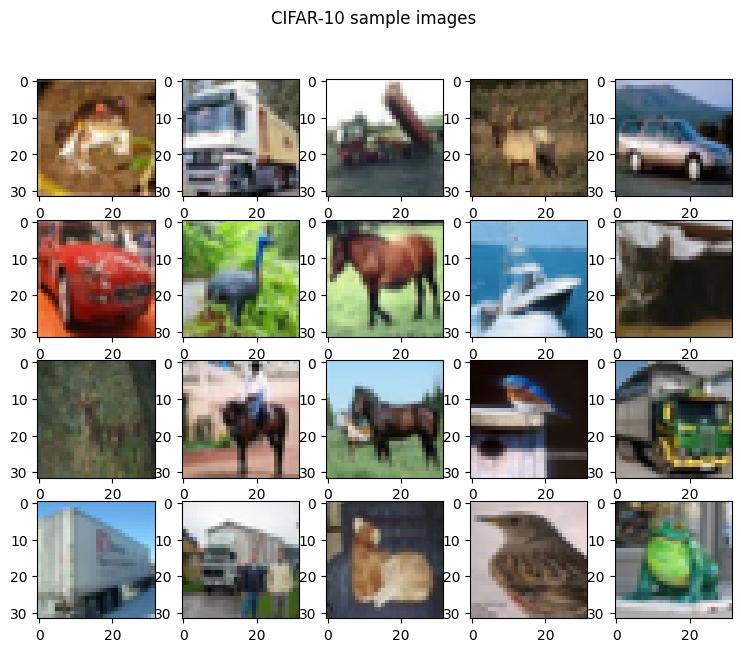

In [14]:
# Visualize 20 CIFAR-10 images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))

plt.suptitle("CIFAR-10 sample images")
plt.show()

### Define _Variational Autoencoder_ architecture

In [15]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )


    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        return x


**Encoder**

In [16]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim

        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()

        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )


    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        return x


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")
        '''
        Input shape: (64, 32, 32, 3)
        conv_block1.shape: (64, 14, 14, 64)
        conv_block2.shape: (64, 5, 5, 128)
        conv_block3.shape: (64, 2, 2, 256)
        flattened shape: (64, 1024)
        Encoder output shape: (64, 100)
        '''

        return None


**Decoder**

In [17]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim

        # self.inp_layer = InputLayer(input_shape = self.latent_dim)

        self.dense0 = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense2 = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.reshape = Reshape((4, 4, 256))

        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )


    def call(self, X):
        # X = self.inp_layer(X)
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")
        return None


In [18]:
encoder = Conv6_Encoder(latent_dim = 100)

In [19]:
decoder = Conv6_Decoder(latent_dim = 100)

In [20]:
x = next(iter(train_dataset))

In [21]:
x.shape

TensorShape([64, 32, 32, 3])

In [22]:
x_enc = encoder(x)

In [23]:
x_recon = decoder(x_enc)

In [24]:
x_enc.shape

TensorShape([64, 100])

In [25]:
x.shape, x_recon.shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 32, 32, 3]))

In [26]:
encoder.shape_computation(x)

Input shape: (64, 32, 32, 3)
conv_block1.shape: (64, 14, 14, 64)
conv_block2.shape: (64, 5, 5, 128)
conv_block3.shape: (64, 2, 2, 256)
flattened shape: (64, 1024)
Encoder output shape: (64, 100)


In [27]:
decoder.shape_computation(x_enc)

Input shape: (64, 100)
first dense layer shape: (64, 100)
second dense layer shape: (64, 1024)
third dense layer shape: (64, 4096)
reshape: (64, 4, 4, 256)
conv transpose layer1 shape: (64, 8, 8, 256)
conv transpose layer2 shape: (64, 8, 8, 256)
conv transpose layer3 shape: (64, 16, 16, 128)
conv transpose layer4 shape: (64, 16, 16, 128)
conv transpose layer5 shape: (64, 32, 32, 64)
conv transpose layer6 shape: (64, 32, 32, 64)
Decoder output shape: (64, 32, 32, 3)


In [28]:
del encoder, decoder, x, x_enc, x_recon

**Sampling for latent space**

In [29]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)


**Define VAE**

In [30]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()

        self.latent_space = latent_space

        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)

        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)


    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 100)

        mu = self.mu(x)
        log_var = self.log_var(x)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''

        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var


    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))



In [31]:
# Initialize VAE model-
model = VAE(latent_space = 100)

In [32]:
# Sanity check-
x = next(iter(train_dataset))

In [33]:
# Forward pass using input data-
x_recon, mu, log_var = model(x)

In [34]:
x.shape, x_recon.shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 32, 32, 3]))

In [35]:
mu.shape, log_var.shape

(TensorShape([64, 100]), TensorShape([64, 100]))

In [36]:
mu.numpy().mean(), mu.numpy().std()

(0.00034643468, 0.012623254)

In [37]:
log_var.numpy().mean(), log_var.numpy().std()

(-0.0007994867, 0.011509618)

In [38]:
del x, x_recon, mu, log_var

In [39]:
# Get model summary-
model.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv6__encoder_1 (Conv6_En  (None, 100)                  1250996   ['input_1[0][0]']             
 coder)                                                                                           
                                                                                                  
 dense_8 (Dense)             (None, 100)                  10100     ['conv6__encoder_1[0][0]']    
                                                                                                  
 dense_9 (Dense)             (None, 100)                  10100     ['conv6__encoder_1[0][0]']

In [40]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (3, 3, 3, 64) has 1728 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 128) has 73728 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 128) has 147456 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 256) has 294912 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (3, 3, 256, 256) has 589824 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (1024, 100) has 102400 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 100) has 10000 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 1024) has 102400 parameters
layer: (1024,) has 0 parameters
layer: (1024,

In [41]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 7315064 trainable parameters


In [42]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

**Train the Model**

In [43]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):

    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )

    # KL-divergence loss-
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss

    return total_loss, recon_loss, kl_loss


In [44]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )

    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)

    # type(grads)
    # list

    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, recon_loss, kl_loss


In [45]:
@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)

    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )

    return total_loss, recon_loss, kl_loss


In [46]:
print(f"Train VAE model for {num_epochs} epochs")

Train VAE model for 100 epochs


In [47]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [48]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

In [49]:
for epoch in range(1, num_epochs + 1):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0

    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )

        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()

    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)

        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()

    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }

    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )


epoch = 1; total train loss = 356293.0327, train recon loss = 34437.1596, train kl loss = 11921.4367; total val loss = 59026.1033, val recon loss = 5516.2598 & val kl loss = 3863.5051
epoch = 2; total train loss = 267678.9568, train recon loss = 24579.6064, train kl loss = 21882.8926; total val loss = 51698.6592, val recon loss = 4674.1390 & val kl loss = 4957.2691
epoch = 3; total train loss = 243137.8071, train recon loss = 21706.3602, train kl loss = 26074.2045; total val loss = 47735.9371, val recon loss = 4247.0704 & val kl loss = 5265.2334
epoch = 4; total train loss = 232700.4028, train recon loss = 20706.4503, train kl loss = 25635.9001; total val loss = 47687.0633, val recon loss = 4253.3094 & val kl loss = 5153.9692
epoch = 5; total train loss = 216221.2702, train recon loss = 18828.8351, train kl loss = 27932.9193; total val loss = 42278.3485, val recon loss = 3649.5365 & val kl loss = 5782.9831
epoch = 6; total train loss = 204831.3868, train recon loss = 17612.5683, train 

In [54]:
# Save trained model at the end of training-
model.save_weights("VAE_CIFAR10_last_epoch.h5", overwrite = True)

In [55]:
import pickle

# Save training metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

In [56]:
# Save validation metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(val_metrics, file)

**Visualize training metrics**

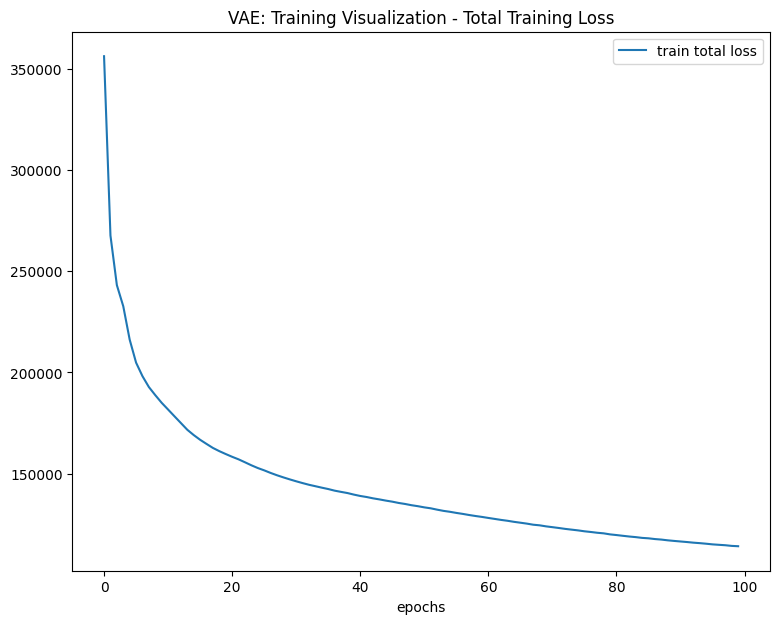

In [57]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

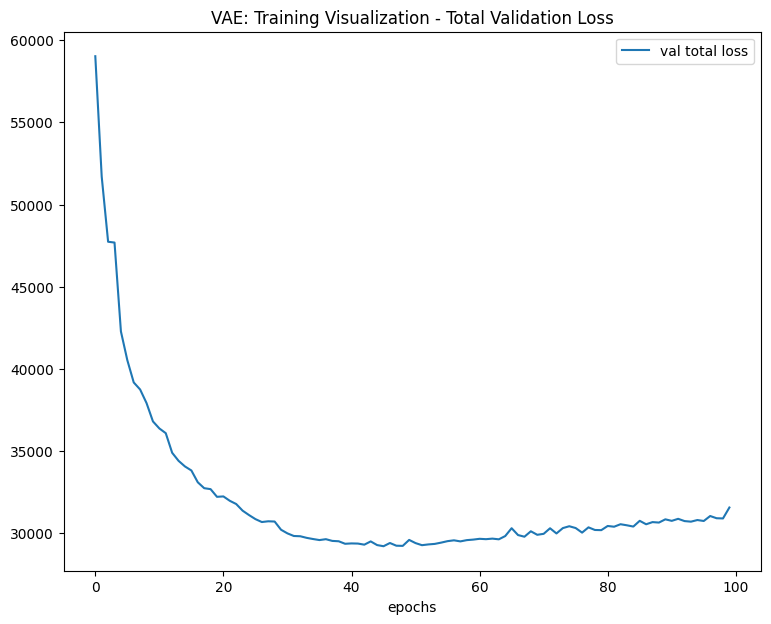

In [58]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

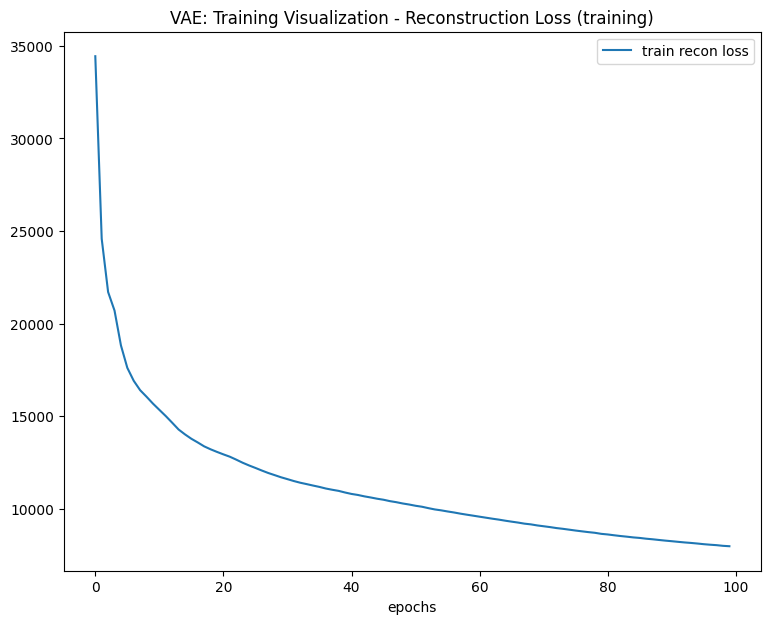

In [59]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

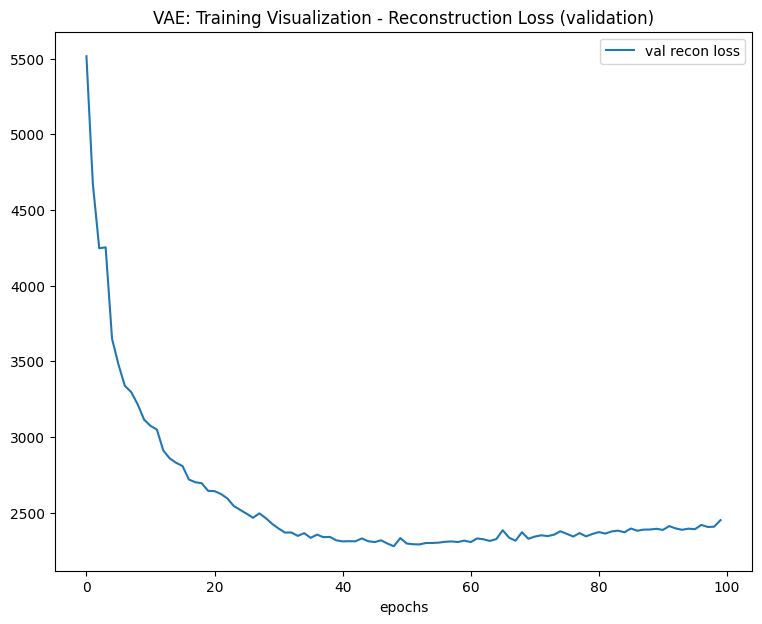

In [60]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

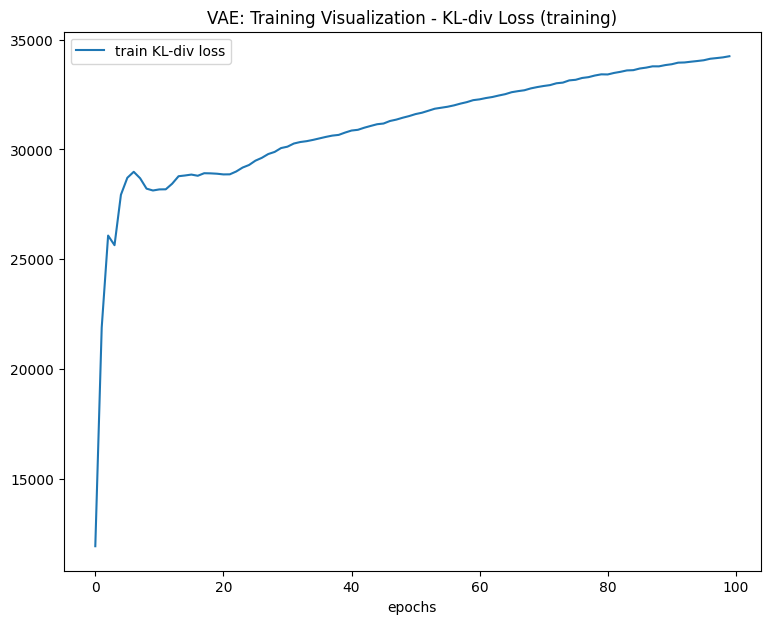

In [61]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

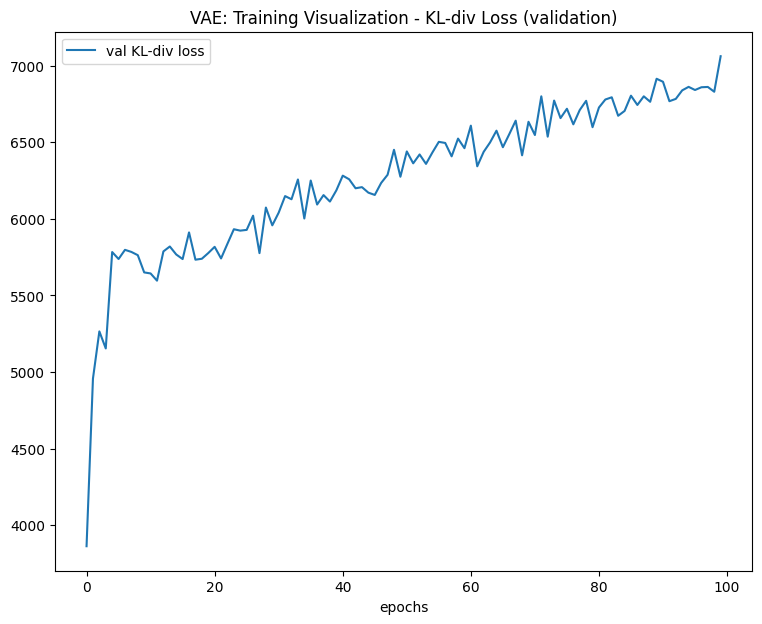

In [62]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

**Visualize reconstructions using trained VAE model**

In [63]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:1000, :])

In [ ]:
# Sanity check-
X_train[:1000, :].shape, X_train_reconstruced.shape

((1000, 32, 32, 3), TensorShape([1000, 32, 32, 3]))

In [ ]:
# Sanity check-
X_train_reconstruced.numpy().shape

(1000, 32, 32, 3)

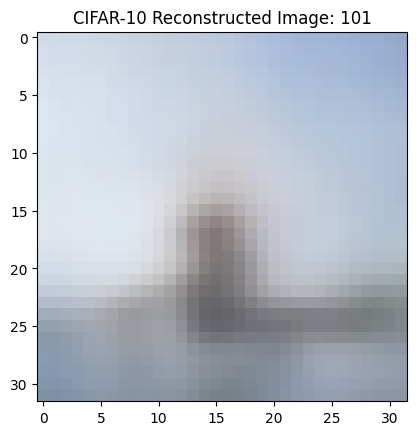

In [64]:
# Visualize one of reconstructed CIFAR-10 image-
img_idx = 100

plt.imshow(X_train_reconstruced[img_idx])
plt.title(f"CIFAR-10 Reconstructed Image: {img_idx + 1}")
plt.show()

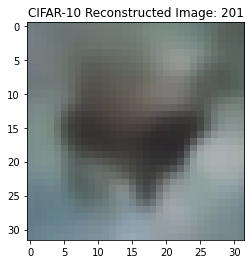

In [ ]:
# Visualize one of reconstructed CIFAR-10 image-
img_idx = 200

plt.imshow(X_train_reconstruced[img_idx])
plt.title(f"CIFAR-10 Reconstructed Image: {img_idx + 1}")
plt.show()

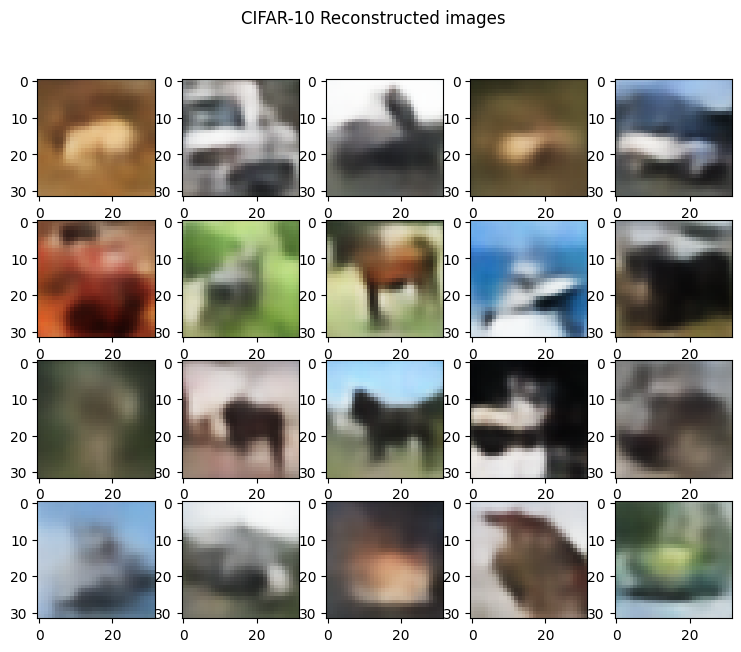

In [65]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i])

plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images2.png')
plt.show()

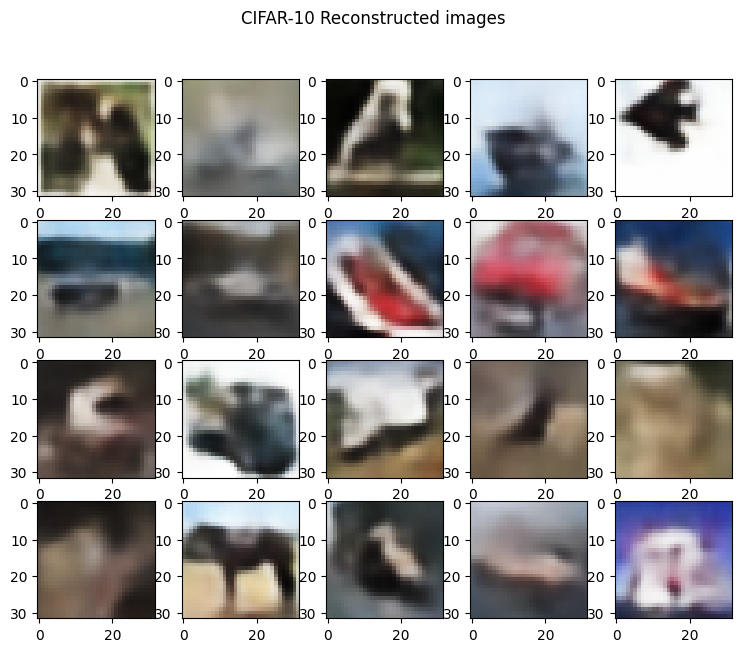

In [66]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i + 500])

plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images3.png')
plt.show()

**Visualize and Check _mu_ and _log_var_ latent space vectors:**

In [68]:
mu.shape, log_var.shape

(TensorShape([1000, 100]), TensorShape([1000, 100]))

In [69]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = -0.0038 & std dev = 0.5267


In [70]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -0.896424 & std dev = 1.5397


In [71]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [72]:
y_train.shape, y_test.shape

((50000,), (10000,))

**Calculate FID**

In [76]:
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 images
(x_train, _), (_, _) = cifar10.load_data()

# Normalize and use a subset for quick demonstration
real_images = x_train[:1000] / 255.0


In [80]:
real_images

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [77]:
generated_images = X_train_reconstruced[500:520]

In [81]:
generated_images

<tf.Tensor: shape=(20, 32, 32, 3), dtype=float32, numpy=
array([[[[0.9024335 , 0.89946157, 0.8731233 ],
         [0.8739787 , 0.8641945 , 0.83051515],
         [0.83202577, 0.8139517 , 0.76564366],
         ...,
         [0.84078074, 0.85083175, 0.78426087],
         [0.86070055, 0.85395294, 0.79464626],
         [0.8731761 , 0.87243825, 0.8129766 ]],

        [[0.89580786, 0.8853817 , 0.8535291 ],
         [0.7719825 , 0.75964665, 0.69968134],
         [0.67206633, 0.64923406, 0.5512894 ],
         ...,
         [0.5550912 , 0.563517  , 0.43952605],
         [0.6544127 , 0.64753455, 0.532813  ],
         [0.8015273 , 0.79672974, 0.71823436]],

        [[0.8809522 , 0.8706343 , 0.8312644 ],
         [0.68211496, 0.6571749 , 0.58855057],
         [0.5391547 , 0.5141964 , 0.41733658],
         ...,
         [0.3866009 , 0.3923405 , 0.26458472],
         [0.5169488 , 0.5113974 , 0.39412788],
         [0.7583587 , 0.7507519 , 0.6626948 ]],

        ...,

        [[0.84991926, 0.8484909 , 0

In [82]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm

# Function to calculate the Fréchet Inception Distance (FID)
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # compute mean and covariance differences
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load pre-trained InceptionV3 model
model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Ensure images are scaled appropriately for InceptionV3 (range [-1, 1])
def preprocess_images_for_inceptionv3(images):
    images_resized = tf.image.resize(images, (299, 299))
    images_preprocessed = tf.keras.applications.inception_v3.preprocess_input(images_resized * 255.0)
    return images_preprocessed

# Example usage
# Assuming `real_images` and `generated_images` are your datasets as NumPy arrays in the range [0, 1]
# Resize and preprocess images
real_images_preprocessed = preprocess_images_for_inceptionv3(real_images)
generated_images_preprocessed = preprocess_images_for_inceptionv3(generated_images)

# Calculate FID
fid_value = calculate_fid(model, real_images_preprocessed, generated_images_preprocessed)
print(f"FID score: {fid_value}")


1/1 [==============================] - 0s 43ms/step
FID score: 90.52682277411029
